In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!tar -xvf spark-3.0.1-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"]= "/content/spark-3.0.1-bin-hadoop2.7"
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
spark = SparkSession.builder.getOrCreate()

In [ ]:
spark.read.csv("MsNPC.csv",header = True).createOrReplaceTempView("npcs")
spark.read.csv("MsPlayer.csv",header = True).createOrReplaceTempView("players")
spark.read.csv("MsWeapon.csv",header = True).createOrReplaceTempView("weapons")
spark.read.csv("MsWeaponType.csv",header = True).createOrReplaceTempView("weapon_types")
spark.read.csv("TransactionDetail.csv",header = True).createOrReplaceTempView("transaction_details")
spark.read.csv("TransactionHeader.csv",header = True).createOrReplaceTempView("transaction_headers")

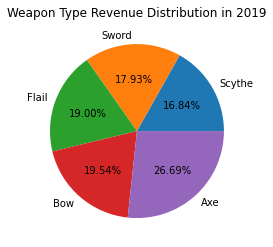

,weapontypename,revenue
0,Scythe,22833000.0
1,Sword,24300000.0
2,Flail,25748000.0
3,Bow,26484000.0
4,Axe,36184000.0


In [ ]:
#a.	Show the percentage of weapon type sold for weapon type that is sold in 2019 using pie plot.
data = spark.sql("""
  Select 
    weapontypename,
    sum(weaponprice*quantity) as revenue
  From weapon_types wt
  JOIN weapons w 
  ON wt.WeaponTypeid = w.WeaponTypeid
  JOIN transaction_details td
  ON w.Weaponid = td.Weaponid
  JOIN transaction_headers th
  ON td.Transactionid = th.Transactionid
  WHERE year(TransactionDate) = '2019'
  GROUP BY wt.weapontypeid, wt.weapontypename
  ORDER BY revenue
""").toPandas()

plt.pie(data["revenue"], labels=data["weapontypename"], autopct="%.2f%%")
plt.title("Weapon Type Revenue Distribution in 2019")
plt.show()
display(data)

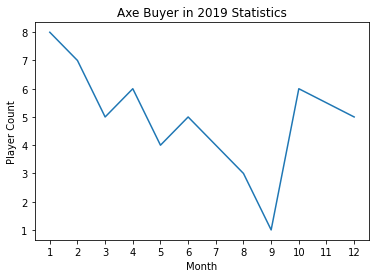

In [ ]:
 #b.	Show the total number of players who bought axe weapon type per month in 2019 using line plot. 
 #Multiple transaction within the same month will be counted as 1.
import matplotlib.pyplot as plt
data = spark.sql("""
  Select 
    count(distinct th.Playerid) as count,
    MONTH(th.transactiondate) as Month
    
  From transaction_headers th 
  JOIN transaction_details td
  ON th.Transactionid = td.transactionid
  JOIN weapons w 
  ON td.Weaponid = w.Weaponid
  JOIN weapon_types wt
  ON w.WeaponTypeid = wt.WeaponTypeid
  WHERE YEAR(th.TransactionDate) = '2019'
  AND wt.WeaponTypeName = 'Axe'
  GROUP BY MONTH(th.TransactionDate)
  ORDER BY Month
 """).toPandas()

plt.plot(data["Month"], data["count"])
plt.xticks(range(1,13))
plt.xlabel("Month")
plt.ylabel("Player Count")
plt.title("Axe Buyer in 2019 Statistics")
plt.show()


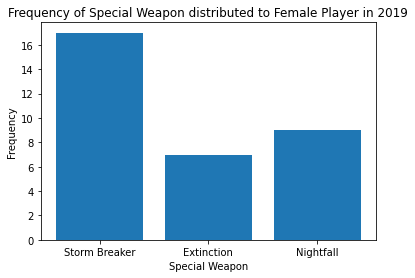

In [ ]:
#b.	Show the frequency of special weapon being distributed to female players in 2019 using bar plot. 
#The player will receive special weapon if their monthly spending reached this following condition: 
#Storm Breaker	1000000 - 1499999
#Nightfall	1500000 – 1999999
#Extinction	> 2000000
data = spark.sql("""
  SELECT 
    PRIZE,
    COUNT (*) as count
  FROM(
    Select 
      p.playerid,
      SUM(w.WeaponPrice * td.Quantity)as Spending,
      CASE 
        WHEN(SUM(w.WeaponPrice * td.Quantity)) BETWEEN 1000000 AND 1499999 THEN 'Storm Breaker'
        WHEN(SUM(w.WeaponPrice * td.Quantity)) BETWEEN 1500000 AND 1999999 THEN 'Nightfall'
        WHEN(SUM(w.WeaponPrice * td.Quantity)) > 2000000 THEN 'Extinction'
      END AS PRIZE
      
    From players p 
    JOIN transaction_headers th 
    ON p.Playerid = th.Playerid
    JOIN transaction_details td
    ON th.Transactionid = td.transactionid
    JOIN weapons w 
    ON td.Weaponid = w.Weaponid
    WHERE p.PlayerGender = 'Female'
    AND YEAR(th.TransactionDate) = '2019'
    GROUP BY p.playerid, MONTH(th.transactiondate)
  )
  WHERE PRIZE IS NOT NULL
  GROUP BY PRIZE
  
 """).toPandas()

plt.bar(data["PRIZE"], data["count"])
plt.xlabel("Special Weapon")
plt.ylabel("Frequency")
plt.title("Frequency of Special Weapon distributed to Female Player in 2019")
plt.show()

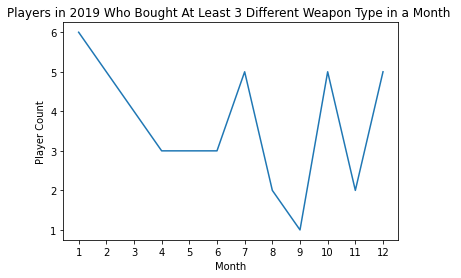

In [ ]:
#c.	Show total number of players per month in 2019 who bought at least 3 different weapon type in a month using line plot.

data = spark.sql("""
  SELECT 
    month,
    count(playerid) as count
  FROM (
    Select 
      th.playerid,
      MONTH(th.transactiondate) as month
      
    From  transaction_headers th
    JOIN transaction_details td
    ON th.Transactionid = td.transactionid
    JOIN weapons w 
    ON td.Weaponid = w.Weaponid
    WHERE YEAR(th.TransactionDate) = '2019'
    GROUP BY  th.playerid, MONTH(th.transactiondate)
    having count (distinct w.weapontypeid) >= 3

    )
    GROUP by month
    order by month 
 """).toPandas()

plt.plot(data["month"], data["count"])
plt.xticks(range(1,13))
plt.xlabel("Month")
plt.ylabel("Player Count")
plt.title("Players in 2019 Who Bought At Least 3 Different Weapon Type in a Month ")
plt.show()

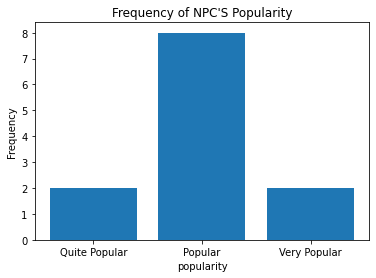

In [ ]:
#d.	Show the frequency of NPC's popularity who has done at least transaction with 5 different player using bar plot. 
#The popularity is determined based on the total income made by the NPC as follows:
#Very Popular	>= 15,000,000
#Popular	>= 7,500,000 – 14,999,999
#Quite Popular	>= 2,500,000 – 7,499,999
#Not Popular	< 2,500,000

data = spark.sql("""
  select
    popularity,
    count(*) as count

  from(
    Select 
      np.npcid,
      sum(td.quantity * w.weaponprice) as income,
      CASE
        WHEN (sum(td.quantity * w.weaponprice)) >= 15000000 THEN 'Very Popular'
        WHEN (sum(td.quantity * w.weaponprice)) BETWEEN 7500000 and 14999999 THEN 'Popular'
        WHEN (sum(td.quantity * w.weaponprice)) Between 2500000 AND 7499999 THEN 'Quite Popular'
        WHEN (sum(td.quantity * w.weaponprice)) < 2500000 THEN 'NOT Popular'
      END as popularity  
    From npcs np
    JOIN transaction_headers th 
    ON np.npcid = th.npcid
    JOIN transaction_details td
    ON th.Transactionid = td.transactionid
    JOIN weapons w 
    ON td.Weaponid = w.Weaponid
    group by np.npcid
    having count(distinct th.playerid)>=5
  )
    group by popularity


  
 """).toPandas()

plt.bar(data["popularity"], data["count"])
plt.xlabel("popularity")
plt.ylabel("Frequency")
plt.title("Frequency of NPC'S Popularity")
plt.show()

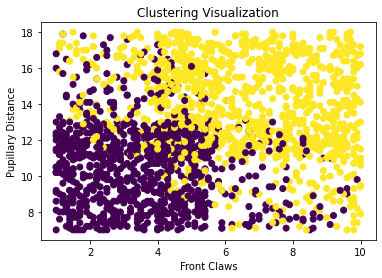

Accuracy: 83.5%


In [ ]:
testing = spark.read.csv("BearTesting.csv", header=True, inferSchema=True)
training = spark.read.csv("BearTraining.csv", header=True, inferSchema=True)

columns = ["Front Claws","Pupillary Distance","Ear Shape"]

testing = testing.na.drop()
training = training.na.drop()

testing = testing.select("Front Claws","Pupillary Distance","Ear Shape","Grizzly")
training = training.select(columns)

from pyspark.sql.functions import when

testing = testing.withColumn(
    "Ear Shape",
    when(testing["Ear Shape"] == "Pointed" , 0).
    when(testing["Ear Shape"] == "Broad" , 1).
    otherwise(2)
)
testing = testing.withColumn(
    "Grizzly",
    when(testing["Grizzly"] == "No",0).otherwise(1)

)

training = training.withColumn(
    "Ear Shape",
    when(training["Ear Shape"] == "Pointed" , 0).
    when(training["Ear Shape"] == "Broad" , 1).
    otherwise(2)
)

from pyspark.ml.feature import VectorAssembler, StandardScaler

assembler = VectorAssembler(inputCols = columns, outputCol = "assembled")
scaler = StandardScaler(inputCol = "assembled", outputCol = "features")

testing = assembler.transform(testing)
training = assembler.transform(training)

testing = scaler.fit(testing).transform(testing)
training = scaler.fit(training).transform(training)

from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=2, seed=1)
model = kmeans.fit(training)
data = model.transform(testing)
data = data.toPandas()
plt.scatter(
    data["Front Claws"],
    data["Pupillary Distance"],
    c = data["prediction"]

)
plt.title ("Clustering Visualization")
plt.xlabel("Front Claws")
plt.ylabel("Pupillary Distance")
plt.show()

c = 0 
for idx, row in data.iterrows():
  if row["Grizzly"] == row["prediction"]:
    c += 1

acc  =c/len(data) * 100
print(f'Accuracy: {acc}%')